In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import timedelta

In [3]:
df = pd.read_csv("long_table_full.csv")

In [5]:
sub = df[["Date", "Ticker", "Return", "7D_Rolling_Mean", "7D_Rolling_Variance", "Volume"]]

In [9]:
sub = sub.sort_values(by=['Ticker', 'Date'])

sub['Return_Lag1'] = sub.groupby('Ticker')['Return'].shift(1)
sub['Volume_Lag1'] = sub.groupby('Ticker')['Volume'].shift(1)
sub = sub.sort_values(by=['Date','Ticker'])

In [10]:
sub

,Date,Ticker,Return,7D_Rolling_Mean,7D_Rolling_Variance,Volume,Return_Lag1,Volume_Lag1
0,2022-01-04,AEVA,-0.034641,NaN,NaN,-0.236455,NaN,NaN
1,2022-01-04,ATRO,0.068327,NaN,NaN,-0.596350,NaN,NaN
2,2022-01-04,DRD,-0.007335,NaN,NaN,0.652325,NaN,NaN
3,2022-01-04,GRPN,-0.015399,NaN,NaN,-0.682022,NaN,NaN
4,2022-01-04,NGVC,0.023417,NaN,NaN,0.537677,NaN,NaN
...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.015736,0.002015,0.278188,-0.006683,-0.300515
6004,2024-12-30,NGVC,0.010384,0.005466,0.000347,-0.097638,-0.025636,-0.056512
6005,2024-12-30,RDFN,-0.032221,-0.001075,0.000798,0.322884,-0.014528,-0.276840
6006,2024-12-30,ROOT,0.005328,0.003229,0.000772,-0.331713,-0.041326,0.276707


In [14]:
macro = pd.read_csv("macro_merged.csv")

In [16]:
macro.DATE = pd.to_datetime(macro.DATE)
sub.Date = pd.to_datetime(sub.Date)

In [17]:
macro.rename(columns={"DATE":"Date"}, inplace = True)

In [19]:
macro.drop(columns= "Unnamed: 0", inplace = True)

In [20]:
merged = pd.merge(sub, macro, on = "Date", how = "left")

In [22]:
merged["Return_Binary"] = (merged.Return > 0)*1

In [23]:
merged

,Date,Ticker,Return,7D_Rolling_Mean,7D_Rolling_Variance,Volume,Return_Lag1,Volume_Lag1,Epi,CPI,FED_RATE,GDP,IPI,Return_Binary
0,2022-01-04,AEVA,-0.034641,NaN,NaN,-0.236455,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,0
1,2022-01-04,ATRO,0.068327,NaN,NaN,-0.596350,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,1
2,2022-01-04,DRD,-0.007335,NaN,NaN,0.652325,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,0
3,2022-01-04,GRPN,-0.015399,NaN,NaN,-0.682022,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,0
4,2022-01-04,NGVC,0.023417,NaN,NaN,0.537677,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.015736,0.002015,0.278188,-0.006683,-0.300515,2.35,3.746553,4.33,23542.349,103.1177,1
6004,2024-12-30,NGVC,0.010384,0.005466,0.000347,-0.097638,-0.025636,-0.056512,2.35,3.746553,4.33,23542.349,103.1177,1
6005,2024-12-30,RDFN,-0.032221,-0.001075,0.000798,0.322884,-0.014528,-0.276840,2.35,3.746553,4.33,23542.349,103.1177,0
6006,2024-12-30,ROOT,0.005328,0.003229,0.000772,-0.331713,-0.041326,0.276707,2.35,3.746553,4.33,23542.349,103.1177,1


In [30]:
df = merged.copy()

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

df = df.dropna(subset=["Return_Binary"])

# Define models
models = {
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ENET": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
}

# Scoring metrics
scoring = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, zero_division=0),
    'Recall': make_scorer(recall_score, zero_division=0),
    'F1': make_scorer(f1_score, zero_division=0)
}

results = []

# Loop by ticker
for ticker in df["Ticker"].unique():
    sub_df = df[df["Ticker"] == ticker].copy()
    X = sub_df.drop(columns=["Return", "Return_Binary", "Ticker", "Date"]).dropna()
    y = sub_df.loc[X.index, "Return_Binary"]

    if len(X) < 100:
        continue

    # Hold out final test set (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    row = {"Ticker": ticker}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        # Elastic Net needs scaling
        if name == "ENET":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            cv_scores = cross_validate(model, X_train_scaled, y_train, cv=cv, scoring=scoring)
        else:
            cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)

        # Store average scores
        row.update({
            f"{name}_Accuracy": cv_scores['test_Accuracy'].mean(),
            f"{name}_Precision": cv_scores['test_Precision'].mean(),
            f"{name}_Recall": cv_scores['test_Recall'].mean(),
            f"{name}_F1": cv_scores['test_F1'].mean()
        })

    results.append(row)

# Compile final CV results (test set untouched)
results_df = pd.DataFrame(results)
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:30:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:30:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:30:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:30:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

  Ticker  RF_Accuracy  RF_Precision  RF_Recall     RF_F1  XGB_Accuracy  \
0   AEVA     0.588950      0.560232   0.507340  0.531212      0.563880   
1   ATRO     0.604076      0.616009   0.571808  0.591698      0.575574   
2    DRD     0.637591      0.636458   0.600000  0.616950      0.609048   
3   GRPN     0.656022      0.653877   0.608288  0.627761      0.627465   
4   NGVC     0.575560      0.561048   0.514338  0.534578      0.536919   
5   RDFN     0.580462      0.519898   0.470174  0.490760      0.562045   
6   ROOT     0.600616      0.560721   0.471698  0.510401      0.575448   
7   TDUP     0.590658      0.545459   0.441074  0.485167      0.587269   

   XGB_Precision  XGB_Recall    XGB_F1  ENET_Accuracy  ENET_Precision  \
0       0.524441    0.514613  0.517986       0.622549        0.611648   
1       0.579449    0.564972  0.570664       0.627563        0.627708   
2       0.597986    0.606897  0.601404       0.629160        0.625176   
3       0.612399    0.618875  0.614325   

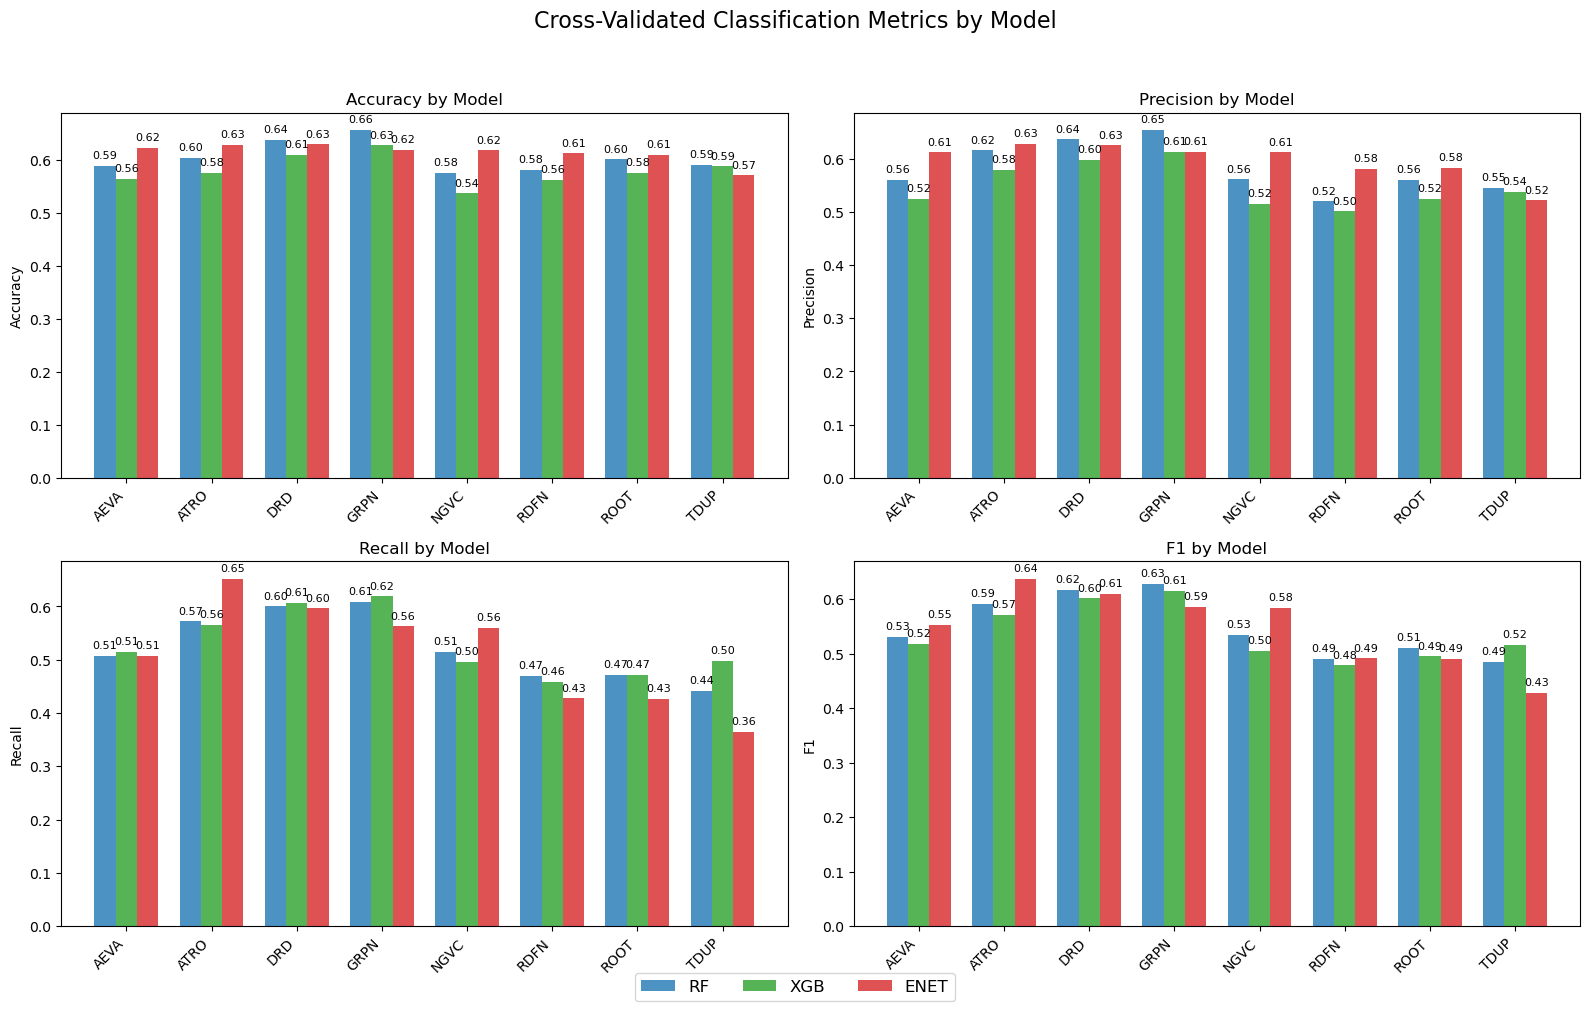

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing results_df
# results_df = pd.read_csv("your_results.csv")

# Plot setup
metrics = ["Accuracy", "Precision", "Recall", "F1"]
model_prefixes = ["RF", "XGB", "ENET"]
colors = {"RF": "tab:blue", "XGB": "tab:green", "ENET": "tab:red"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

x = range(len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bar_width = 0.25

    for i, model in enumerate(model_prefixes):
        offset = (i - 1) * bar_width  # shift bars left, center, right
        scores = results_df[f"{model}_{metric}"]
        bars = ax.bar(
            [xi + offset for xi in x],
            scores,
            width=bar_width,
            label=model,
            color=colors[model],
            alpha=0.8
        )

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    ax.set_title(f"{metric} by Model", fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["Ticker"], rotation=45, ha='right')

fig.suptitle("Cross-Validated Classification Metrics by Model", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(model_prefixes, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.02))
plt.savefig("model.png", dpi = 300)
plt.show()

